In [1]:
import pandas as pd
import numpy as np

In [2]:
insurance = pd.read_csv('/Users/DericoDehnielsen/Downloads/insurance.csv')

In [3]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


check for null values

In [4]:
insurance.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [5]:
insurance.shape

(1338, 7)

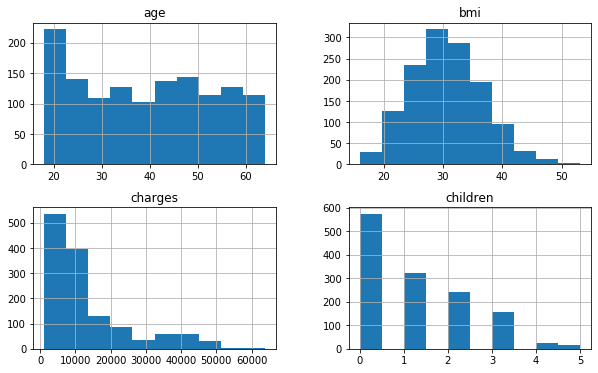

In [6]:
import matplotlib.pyplot as plt

insurance.hist(figsize=(10,6))
plt.show()

In [7]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_enc = OrdinalEncoder()

#male
insurance_sex = insurance[['sex']]
male_encoded = ordinal_enc.fit_transform(insurance_sex)

#smoker
insurance_smoker = insurance[['smoker']]
smoker_encoded = ordinal_enc.fit_transform(insurance_smoker)

#region
insurance_region = insurance[['region']]
region_encoded = ordinal_enc.fit_transform(insurance_region)

insurance.drop(['sex', 'smoker', 'region'],axis=1, inplace=True)

insurance['male'] = male_encoded
insurance['smoker'] = smoker_encoded
insurance['region'] = region_encoded

In [8]:
insurance.head()

,age,bmi,children,charges,male,smoker,region
0,19,27.900,0,16884.92400,0.0,1.0,3.0
1,18,33.770,1,1725.55230,1.0,0.0,2.0
2,28,33.000,3,4449.46200,1.0,0.0,2.0
3,33,22.705,0,21984.47061,1.0,0.0,1.0
4,32,28.880,0,3866.85520,1.0,0.0,1.0


In [9]:
insurance[['male', 'smoker', 'region']] = insurance[['male', 'smoker', 'region']].astype(int)

In [10]:
insurance.head()

,age,bmi,children,charges,male,smoker,region
0,19,27.900,0,16884.92400,0,1,3
1,18,33.770,1,1725.55230,1,0,2
2,28,33.000,3,4449.46200,1,0,2
3,33,22.705,0,21984.47061,1,0,1
4,32,28.880,0,3866.85520,1,0,1


check for correlation

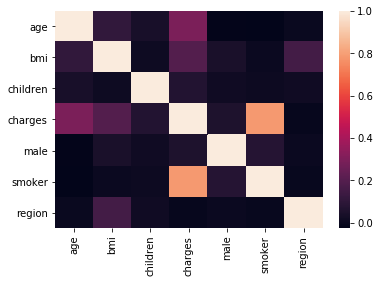

In [18]:
import seaborn as sns

insurance_corr = insurance.corr()
sns.heatmap(insurance_corr, annot=False)
plt.show()

In [17]:
insurance_corr['charges'].sort_values(ascending=False)

charges     1.000000
smoker      0.787251
age         0.299008
bmi         0.198341
children    0.067998
male        0.057292
region     -0.006208
Name: charges, dtype: float64

drop attributes with low correlation value

In [19]:
insurance.drop(['region'], axis=1, inplace=True)

split data to train & test datasets

In [20]:
from sklearn.model_selection import train_test_split

X = insurance.drop('charges', axis=1)
y = insurance['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [21]:
from sklearn.preprocessing import StandardScaler

X_train_2 = StandardScaler().fit_transform(X_train)

predict with linear regression

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

In [24]:
linreg = LinearRegression()

linreg_scores = cross_val_score(linreg, X_train_2, y_train, cv=10, scoring = 'neg_mean_squared_error')
linreg_score = np.sqrt(-linreg_scores)

def display_score(scorelist):
    print(f'scores = {scorelist}')
    print(f'mean = {scorelist.mean()}')
    print(f'std = {scorelist.std()}')
    
display_score(linreg_score)

scores = [5792.10931907 5549.90781931 6135.07147402 7575.98688622 5713.63170282
 7167.28323293 5570.83631463 5958.12837918 5398.3853572  5987.84444781]
mean = 6084.918493319625
std = 683.2458236061739


predict with random forest regressor

In [25]:
from sklearn.ensemble import RandomForestRegressor

In [29]:
rfreg = RandomForestRegressor()

rfreg_scores = cross_val_score(rfreg, X_train_2, y_train, cv=10, scoring='neg_mean_squared_error')
rfreg_score = np.sqrt(-rfreg_scores)

display_score(rfreg_score)

scores = [4382.61647354 5256.4908529  5170.36328306 6370.86942894 4025.25279739
 6054.25745925 5160.18857525 5198.94360839 4893.63171008 4798.1190245 ]
mean = 5131.073321329888
std = 660.4812215240257


tune the model using gridsearchcv

In [39]:
from sklearn.model_selection import GridSearchCV

n_list = list(range(1,31))
features_list = list(np.linspace(0,1,10).round(2))

param_grid = {
    'bootstrap': [False],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [3, 30, 50, 80, 100],
    'max_features':[1,2,3,4,5]}

rf_reg = RandomForestRegressor()

grid_search = GridSearchCV(rf_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(X_train_2, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [40]:
df = pd.DataFrame(grid_search.cv_results_)
df[['mean_test_score', 'std_test_score', 'params']].head()

,mean_test_score,std_test_score,params
0,-3.599175e+07,6.889879e+06,"{'bootstrap': False, 'max_features': 1, 'min_s..."
1,-2.927087e+07,5.983691e+06,"{'bootstrap': False, 'max_features': 1, 'min_s..."
2,-2.788535e+07,5.481603e+06,"{'bootstrap': False, 'max_features': 1, 'min_s..."
3,-2.871683e+07,5.887990e+06,"{'bootstrap': False, 'max_features': 1, 'min_s..."
4,-2.821416e+07,4.612660e+06,"{'bootstrap': False, 'max_features': 1, 'min_s..."


In [41]:
grid_search.best_params_

{'bootstrap': False,
 'max_features': 3,
 'min_samples_split': 12,
 'n_estimators': 100}

In [42]:
np.sqrt(-grid_search.best_score_)

4926.068853155678

predict test datasets with the best model

In [43]:
X_test_2 = StandardScaler().fit_transform(X_test)
final_model = grid_search.best_estimator_
final_prediction = final_model.predict(X_test_2)

check the mean squared error and r squared value

In [44]:
from sklearn.metrics import r2_score, mean_squared_error

print(f'mean squared error = {np.sqrt(mean_squared_error(y_test, final_prediction))}')
print(f'r squared value = {r2_score(y_test, final_prediction)}')

mean squared error = 4469.937479631604
r squared value = 0.8620556385888797


predicting my insurance charge

In [60]:
my_attributes = [17, 19.7, 0, 1, 0]
print(f'my predicted insurance charge: ${int(final_model.predict([my_attributes]))}')

my predicted insurance charge: $16468


In [61]:
print(f"insurance charge mean: ${int(insurance['charges'].mean())}")

insurance charge mean: $13270
